# World of Supply

A simulation environment for multi-echelon supply chain optimization problems. 

In [1]:
import numpy as np
from tqdm import tqdm as tqdm
import importlib

# Core Simulation Logic and Rendering

In this section, we test the core simulator and renderer (without RL adapters and integrations).

100%|██████████| 10000/10000 [00:04<00:00, 2313.32it/s]


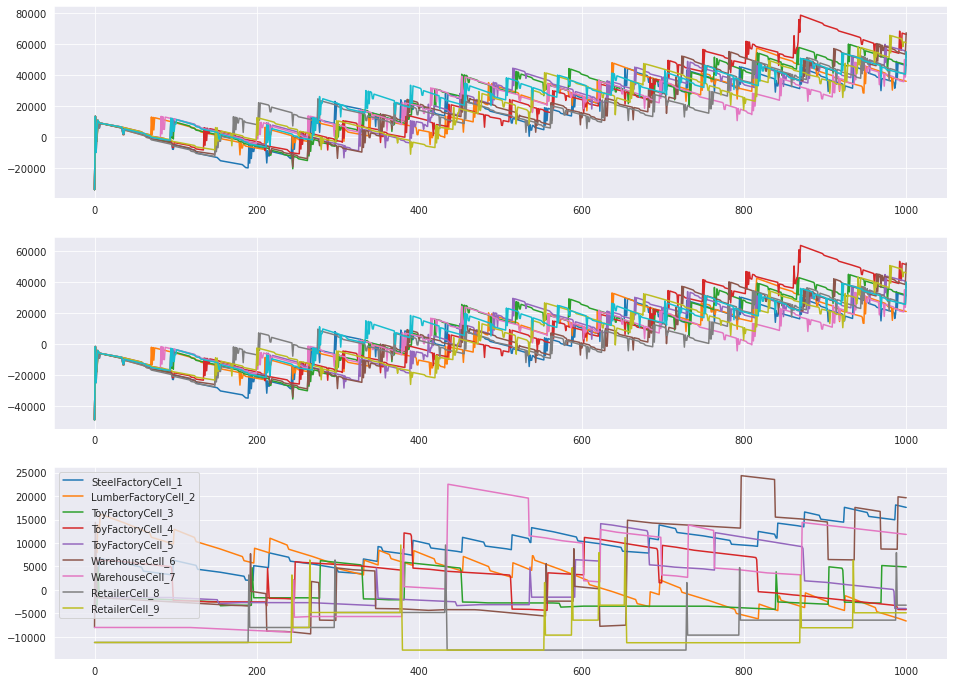

100%|██████████| 300/300 [02:00<00:00,  2.48it/s]


Rendering the animation...


<Figure size 1420x1712 with 0 Axes>

In [3]:
import world_of_supply_environment as ws
import world_of_supply_renderer as wsr
import world_of_supply_tools as wst
for module in [ws, wsr, wst]:
    importlib.reload(module)
        
# Measure the simulation rate, steps/sec
eposod_len = 1000
n_episods = 10
world = ws.WorldBuilder.create()
tracker = wst.SimulationTracker(eposod_len, n_episods, world.facilities.keys())
with tqdm(total=eposod_len * n_episods) as pbar:
    for i in range(n_episods):
        world = ws.WorldBuilder.create()
        policy = ws.SimpleControlPolicy()
        for t in range(eposod_len):
            outcome = world.act(policy.compute_control(world))
            tracker.add_sample(i, t, world.economy.global_balance().total(), 
                               {k: v.total() for k, v in outcome.facility_step_balance_sheets.items() } )
            pbar.update(1)        
tracker.render()
    
# Test rendering
renderer = wsr.AsciiWorldRenderer()
frame_seq = []
world = ws.WorldBuilder.create()
policy = ws.SimpleControlPolicy()
for epoch in tqdm(range(300)):
    frame = renderer.render(world)
    frame_seq.append(np.asarray(frame))
    world.act(policy.compute_control(world))

print('Rendering the animation...')
wsr.AsciiWorldRenderer.plot_sequence_images(frame_seq)

# Policy Training

In this section, we run RLlib policy trainers. These trainers evaluate the hand coded policy, learn a new policy from scrath, or learn a new policy by playing against the hand coded policy.

In [ ]:
import world_of_supply_rllib as wsrl
import world_of_supply_rllib_training as wsrt
for module in [wsrl, wsrt]:
    importlib.reload(module)

# Policy training
#trainer = wsrt.play_baseline(n_iterations = 1)
trainer = wsrt.train_ppo(n_iterations = 100)

# Policy Evaluation

In this section, we evaluate the trained policy.

### Rendering One Episod for the Trained Policy

2020-04-26 20:15:31,560	INFO resource_spec.py:212 -- Starting Ray with 72.56 GiB memory available for workers and up to 35.09 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-26 20:15:32,241	INFO services.py:1148 -- View the Ray dashboard at localhost:8265
/home/ubuntu/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
  2%|▏         | 12/700 [00:00<00:09, 74.11it/s]

Environment: action space Tuple(Discrete(8), Discrete(5), Discrete(3), Discrete(3), Discrete(5)), observation space Box(45,)


100%|██████████| 700/700 [00:01<00:00, 607.33it/s]


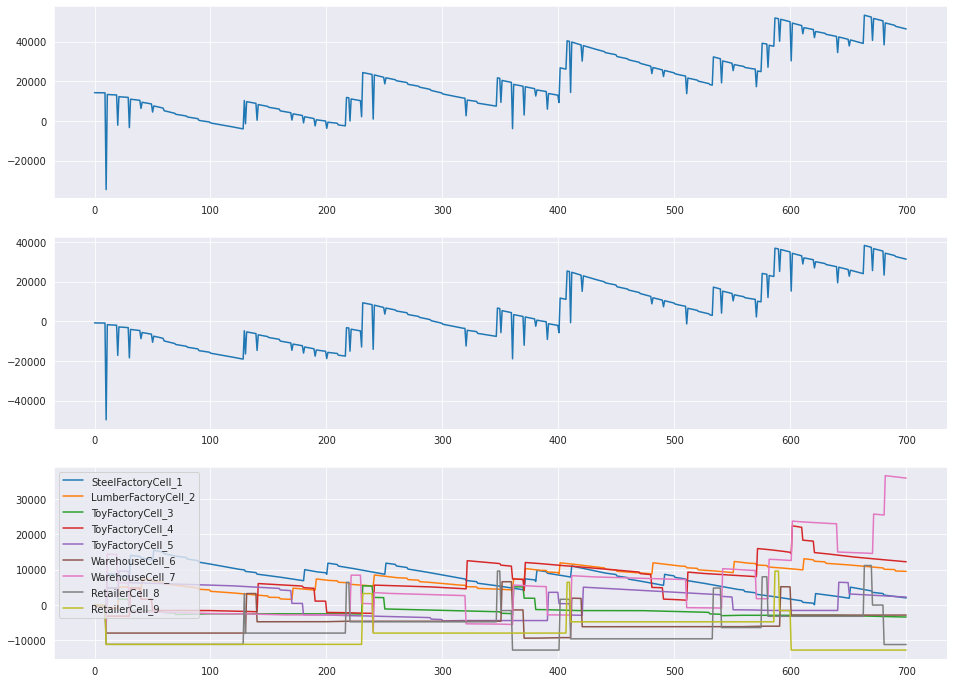

In [8]:
import world_of_supply_renderer as wsren
import world_of_supply_tools as wst
import world_of_supply_rllib as wsrl
import world_of_supply_rllib_training as wstr
for module in [wsren, wst, wsrl, wstr]:
    importlib.reload(module)

# Parameters of the tracing simulation
policy_mode = 'baseline' # 'baseline' or 'trained'
episod_duration = 700
steps_to_render = None  # (0, episod_duration) or None

# Create the environment
renderer = wsren.AsciiWorldRenderer()
frame_seq = []
env_config_for_rendering = wstr.env_config.copy()
env_config_for_rendering.update({
    'downsampling_rate': 1
})
env = wsrl.WorldOfSupplyEnv(env_config_for_rendering)
print(f"Environment: action space {env.action_space}, observation space {env.observation_space}")
states = env.reset()
infos = None
    
def load_policy(facility_id):
    if policy_mode == 'baseline':
        return wsrl.SimplePolicy(env.observation_space, env.action_space, wsrl.SimplePolicy.get_config_from_env(env))
    
    if policy_mode == 'trained':
        policy_map = wstr.policy_mapping_global.copy()
        wstr.update_policy_map(policy_map, 0, 0)     # apply all updates
        return trainer.get_policy(wstr.create_policy_mapping_fn(policy_map)(facility_id))

policies = {}
rnn_states = {}
for facility_id in states.keys():
    policies[facility_id] = load_policy(facility_id)
    rnn_states[facility_id] = policies[facility_id].get_initial_state()
    
# Simulation loop
tracker = wst.SimulationTracker(episod_duration, 1, env.world.facilities.keys())
for epoch in tqdm(range(episod_duration)):
    action_dict = {}
    if epoch % wstr.env_config['downsampling_rate'] == 0:
        for facility_id, state in states.items():
            policy = policies[facility_id]
            rnn_state = rnn_states[facility_id]
        
            if infos is not None and facility_id in infos:
                action_dict[facility_id], rnn_state, _ = policy.compute_single_action( state, info=infos[facility_id], state=rnn_state ) 
            else:
                action_dict[facility_id], rnn_state, _ = policy.compute_single_action( state, state=rnn_state )   
   
    states, rewards, dones, infos = env.step(action_dict)
    tracker.add_sample(0, epoch, env.world.economy.global_balance().total(), rewards)
    
    if steps_to_render is not None and epoch >= steps_to_render[0] and epoch < steps_to_render[1]:
        frame = renderer.render(env.world)
        frame_seq.append(np.asarray(frame))
 
tracker.render()

if steps_to_render is not None:
    print('Rendering the animation...')
    wsren.AsciiWorldRenderer.plot_sequence_images(frame_seq)